<a href="https://colab.research.google.com/github/dave-heslop74/EMSC2010-W3-P2/blob/main/EMSC2010_W3_P2_NB1_uXXXXXXX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EMSC2010_W3_P2_NB1
---

*   Class: EMSC2010
*   Week: 3
*   Session: Practical 2

---

From GitHub, you can open this notebook in Google Colab using the 'Open in Colab' button. Then:

1. Change the notebook name to include your U-number (e.g EMSC2010_W3_P2_NB1_uXXXXXXX.ipynb)
2. Save to Google Drive (*File* >>> *Save a copy in Drive*)

Any edits you make will be saved in your Google Drive. To save your editted version to GitHub

3. Commit to GitHub (*File* >>> *Save a copy in GitHub*)
4. Select the repository for your commit (same as your original repository)
5. Give a brief commit message (e.g. 'Commit including adjustment to labels')
6. Check your GitHub repository, a copy of your notebook should be there.

---

Because Google Drive is saving your work and the work of your collaborators automatically, you don't need to commit all minor edits to GitHub. Rather commit when you want to archive a version of your notebook because you have completed a substantial task.

# Plotting the global distribution of earthquakes and plate tectonic boundaries

In this notebook we'll plot the location and characteristics of earthquakes above magnitude 5. We'll also add lines showing the boundaries of the main tectonic plates. Importantly, we be using ```cartopy```, which is a package commonly used for making maps.

## Setting up Colab
We'll install packages the packages we need that are not already part of Colab.

Importantly, we'll install ```cartopy``` for making maps

In [2]:
!apt-get install -qq libgdal-dev libgeos-dev libproj-dev
!pip install cartopy #install cartopy
!pip install gspread google-auth

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 81.9 MB/s eta 0:00:00


In [3]:
import pandas as pd #used to read and clean data
import matplotlib.pyplot as plt #used for data plotting
from google.colab import auth #imports the Colab authentication module
import gspread #enables interaction with Google Sheets
from google.auth import default #use for authentication
import cartopy.crs as ccrs #import map coordinate reference systems
import cartopy.feature as cfeature #imports Cartopy's map features (land, ocean, etc)

## Read in the data from your Google Sheet

Authentication to allow the notebook to interact with files in your Google Drive (don't worry about the specifics)

In [4]:
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

We need to read in pre-existing data sets, that I have already uploaded to my Google Drive. The first data set is earthquake longitude, latitude, magnitude and depth.

In [5]:
# Replace the url with your actual shared earthquake Google Sheet URL
spreadsheet_url_EQ = 'https://docs.google.com/spreadsheets/d/1IgaMYJFERBNukYtYWNApVm9dD1r7i6yHDJ9h2yUaWxM/edit?usp=sharing'
worksheet_EQ = gc.open_by_url(spreadsheet_url_EQ).worksheet('Sheet1') #replace 'Sheet 1' with your worksheet name
data_EQ = worksheet_EQ.get_all_values() #get all the data from the worksheet
df_EQ = pd.DataFrame(data_EQ[1:], columns=data_EQ[0]) #read the data into a dataframe assuming the first row is the header information
df_EQ = df_EQ.apply(pd.to_numeric, errors="coerce") #sometimes the data is read as text, so make sure it is numbers

We can show the top of the earthquake dataframe (```df_EQ```) including the header information.

In [6]:
df_EQ.head()

,latitude [deg],longitude [deg],depth [km],magnitude
0,-58.7165,-25.7228,94.055,5.2
1,37.0918,136.5865,29.140,5.1
2,1.9973,126.4390,60.724,5.0
3,-35.7823,-102.3193,10.000,5.2
4,-3.2636,101.3136,54.548,5.1


The second data set is plate boundary longitude and latitude.

In [7]:
# Replace the url with your actual shared plate boundary Google Sheet URL
spreadsheet_url_PB = 'https://docs.google.com/spreadsheets/d/1AHiKfRqrAy8JxYvIBhf4-pSIZyFLiwpkxKE0rddFnGc/edit?usp=sharing'
worksheet_PB = gc.open_by_url(spreadsheet_url_PB).worksheet('Sheet1') #replace 'Sheet 1' with your worksheet name
data_PB = worksheet_PB.get_all_values() #get all the data from the worksheet
df_PB = pd.DataFrame(data_PB[1:], columns=data_PB[0]) #read the data into a dataframe assuming the first row is the header information
df_PB = df_PB.apply(pd.to_numeric, errors="coerce") #sometimes the data is read as text, so make sure it is numbers

We can show the top of the plate boundary dataframe (```df_PB```) including the header information.

In [8]:
df_EQ.head()

,latitude [deg],longitude [deg],depth [km],magnitude
0,-58.7165,-25.7228,94.055,5.2
1,37.0918,136.5865,29.140,5.1
2,1.9973,126.4390,60.724,5.0
3,-35.7823,-102.3193,10.000,5.2
4,-3.2636,101.3136,54.548,5.1


We'll start by making a global map with a 'Robinson' projection. We'll add in the continents and coastlines and then:
1. Plot earthquake locations as coloured points, where the color indicates magnitude.
2. Plot the boundaries of tectonic plates as red lines.

/usr/local/lib/python3.12/dist-packages/shapely/creation.py:218: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, np.intc(handle_nan), out=out, **kwargs)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


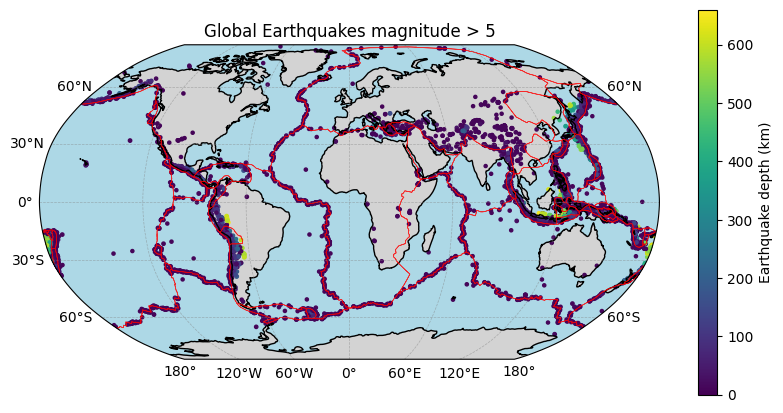

In [9]:
# --------------------------------------------------
# MAP SETUP & ADD FEATURES
# --------------------------------------------------

# Define the map projection to use (Robinson is a global, visually balanced projection)
my_projection = ccrs.Robinson()

# Create a Matplotlib figure with a width of 10 inches and height of 5 inches
fig = plt.figure(figsize=(10, 5))

# Create a map axis using the chosen Cartopy projection
ax = plt.axes(projection=my_projection)

# Draw coastlines on the map for geographic reference
ax.coastlines()

# Set the map extent to cover the entire globe
ax.set_global()

# Add land areas to the map and color them light gray
ax.add_feature(cfeature.LAND, facecolor="lightgray")

# Add ocean areas to the map and color them light blue
ax.add_feature(cfeature.OCEAN, facecolor="lightblue")

# --------------------------------------------------
# PLOT EARTHQUAKE LOCATIONS (MAGNITUDE SHOWN AS COLOUR)
# --------------------------------------------------

# Plot earthquake locations as a scatter plot
sc_EQ = ax.scatter( df_EQ['longitude [deg]'], # Longitudes of earthquakes (x-coordinates)
    df_EQ['latitude [deg]'], # Latitudes of earthquakes (y-coordinates)
    c=df_EQ['depth [km]'], # Color the markers by earthquake depth
    s=df_EQ['magnitude'], # Scale marker size by earthquake magnitude
    cmap="viridis", # Use the 'viridis' colormap for depth values
    transform=ccrs.PlateCarree()  # Specify that the input coordinates are in Plate Carrée (lon/lat) projection
)

# --------------------------------------------------
# PLOT TECTONIC PLATE BOUNDARIES
# --------------------------------------------------

# Plot tectonic plate boundary lines on top of the map
ax.plot(df_PB['longitude [deg]'], # Longitudes of plate boundary points
    df_PB['latitude [deg]'], # Latitudes of plate boundary points
    color="r", # Set the line color to red
    linewidth=0.5, # Set the line width to be thin
    alpha=0.8, # Make the lines slightly transparent
    transform=ccrs.PlateCarree() # Specify that the coordinates are given in longitude/latitude
)

# Add a colorbar linked to the earthquake scatter plot
# This shows how marker color corresponds to earthquake depth
plt.colorbar(sc_EQ, label="Earthquake depth (km)")

# Add a title to the figure
plt.title("Global Earthquakes magnitude > 5")

# --------------------------------------------------
# ADD GRIDLINES AND LABELS
# --------------------------------------------------

# Add latitude and longitude gridlines to the map
gl = ax.gridlines(
    draw_labels=True,     # Show coordinate labels on the map edges
    linewidth=0.5,        # Set gridline thickness
    color="gray",         # Set gridline color
    alpha=0.5,            # Make gridlines semi-transparent
    linestyle="--"        # Use dashed gridlines
)

# Disable labels at the top of the map
gl.top_labels = False

# Disable labels on the right side of the map
gl.right_labels = False


Now imagine we want to try a different projection, for example 'Mercator' and center the map on a longitude of 150 degrees east. We cannot update the projection on the map we created above. Rather, we have to make a new map. This isn't difficult because we can simply copy and paste the commands from above. In the cell below, create a version of the map which uses the command:
```my_projection=ccrs.Mercator(central_longitude=150)```

In [ ]:
# --------------------------------------------------
# ENTER YOUR MAP CODE HERE
# --------------------------------------------------


We can also restrict the map to a region based on limiting the longitude and latitude ranges. Regional maps work well with a `LambertConformal` projection. For example, we can create a projection with a defined center of longitude = 140 degrees east and latitude = 35 degrees north using:

```my_projection=ccrs.LambertConformal(central_longitude=140,central_latitude=35)```

Then to limit the map region, you should replace the command:

```ax.set_global()```

with

```ax.set_extent([120, 150, 25, 50], crs=ccrs.PlateCarree()) #limit map to show Japan```


In [ ]:
# --------------------------------------------------
# ENTER YOUR MAP CODE HERE
# --------------------------------------------------

Finally, using the ```plt.subplot``` command we studied in the previous session, create two subplots along a row. In the left panel make a histogram of earthquake magnitude and in the right panel plot earthquake depth (x-axis) versus earthquake magnitude (y-axis). Remember to label the plot axes, etc.

In [1]:
# --------------------------------------------------
# ENTER YOUR PLOT CODE HERE
# --------------------------------------------------